This class is based on the excellent work done by natrocis

The repository is here:

https://natronics.github.io/blag/2014/gps-viz-1/

# GPS Carrier

GPS has 1 base frequencies:

L1: 1575.42 MHz (154 x 10.23 MHz) 
L2: 1227.60 MHz (120 x 10.23 MHz)

For this notebook, we will focus on the more commonly used L1 frequency

Let's first synthesize the GPS carrier using this frequency

In [1]:
# import all the libraries
%matplotlib inline
import matplotlib.pyplot as plt
from math import sin, pi
import random
from IPython.display import display, HTML
import numpy as np
from scipy.signal import correlate
from scipy.signal import periodogram, welch

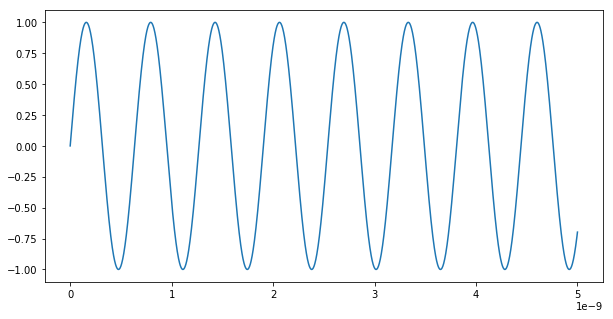

In [2]:
#the GPS carrier

#set the standard matplolib figure size
plt.rcParams['figure.figsize'] = [10, 5]

f = 154 * 10.23e6
carrier_function = lambda x: sin(2*pi*f*x)

x_axis = np.linspace(0,5e-9,2000)
carrier = []
for i in x_axis:
    carrier.append(carrier_function(i))

plt.plot(x_axis, carrier)
plt.show()

This base frequency is modulated by a code.
The GPS codes are called "pseudo random numbers", or PRNs.
The idea is that a true random number sequence is unique, meaning that it has very good autocorrelation and very poor (low) cross correlation with everything else.
We can't have a true random generator in a computer, so we design a pseudo random number generator.
They are generated by a known function and the GPS PRNs, a pair of shift registers

It works by calculating the "modulo 2" of 2 bits and shifting the bits one position.
Let's look at an example for one shift register:

In [8]:
# Make a shift register of length 10
# initilize with all 1's
G1 = [1 for i in range(10)]
print('start with a clean, 10 bit long stream of ones: ', G1)

start with a clean, 10 bit long stream of ones:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Now, if we take a couple bits and calculate the modulo 2, we get:

In [9]:
fb3 = G1[3-1]           # position 3
fb10 = G1[10-1]         # position 10
fb = (fb3 + fb10) % 2   # modulo 2 add
print('Modulo 2 of bits 3 and 10: ', fb)

Modulo 2 of bits 3 and 10:  0


We just push the bits to the right, drop the last one and insert the calculated bit in the front:

In [10]:
# shift everything one place to the right
for i in reversed(range(len(G1[1:]))):
    G1[i+1] = G1[i]

# feedback
G1[0] = fb

print(G1)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


And so on...

We can put this in a function:

In [11]:
# putting is all in a function and calulating G1



def shift(register, feedback, output):
    """GPS Shift Register
    
    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:
    
    """
    
    # calculate output
    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]
        
    # modulo 2 add feedback
    fb = sum([register[i-1] for i in feedback]) % 2
    
    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]
        
    # put feedback in position 1
    register[0] = fb
    
    return out

Now, we can calulate the GPS PRN.
It uses 2 shift registers, so we need G1 and G2

In [13]:
# Calculate the first 10 bits of a PRN

G1 = [1 for i in range(10)]
G2 = [1 for i in range(10)]

# work out first 10 bits
prn_seq = []
for i in range(10):
    g1 = shift(G1, [3,10], [10]) #feedback 3,10, output 10
    g2 = shift(G2, [2,3,6,8,9,10], [2,6]) #feedback 2,3,6,8,9,10, output 2,6 for sat 1
    prn_seq.append((g1 + g2) % 2)

print('First 10 bits of a PRN: ', prn_seq)

First 10 bits of a PRN:  [1, 1, 0, 0, 1, 0, 0, 0, 0, 0]


OK, with this sequence, we can now modulate the carrier.
But, what is the modulation frequency?

The C/A code is transmitted on the L1 frequency at 1.023 MHz.

Transmitted at this frequency and generated as described, this is called the C/A code, or course acquisition.

So let's look at the C/A code frequency compared to the carrier

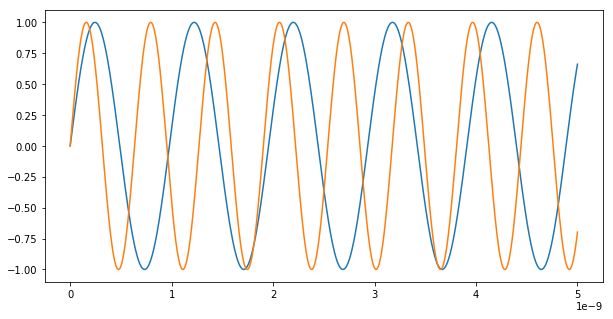

In [15]:
f_mod = 1023e6
modulation_function = lambda x: sin(2*pi*f_mod*x)

x_axis = np.linspace(0,5e-9,2000)
modulation = []
for i in x_axis:
    modulation.append(modulation_function(i))

plt.plot(x_axis, modulation)
plt.plot(x_axis, carrier)
plt.show()

OK, so now let's use our PRN sequence to modulate the carrier using this modulation frequency:

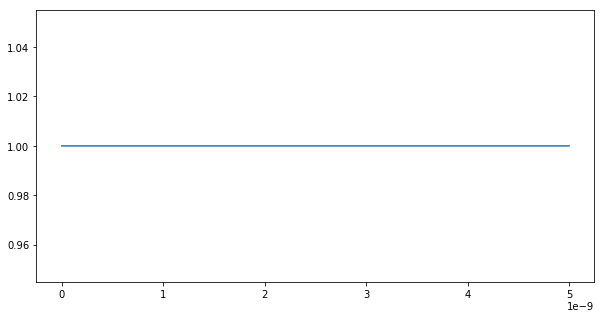

In [17]:
# modualtion period
prn_period = 1/1023e6 #s
mod_prn = []
counter = 0
for i in x_axis:
    if counter > len(prn_seq):
        counter = 0
    counter += int(i % prn_period)
    mod_prn.append(prn_seq[counter])
plt.plot(x_axis, mod_prn)
plt.show()

In [18]:
prn_period

9.775171065493647e-10